In [1]:
from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# Assuming HAM10000 is in archive2.zip
zip_path = '/content/drive/MyDrive/archive2.zip'

if os.path.exists(zip_path):
    print("\nUnzipping ham10000 dataset...")
    os.makedirs('ham10000_data', exist_ok=True)
    os.system(f'unzip -q "{zip_path}" -d ham10000_data/')
    print("Unzipping completed successfully.")
else:
    print(f"\nError: The file was not found at the specified path: {zip_path}")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully.

Unzipping ham10000 dataset...
Unzipping completed successfully.


In [2]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- Define Parameters ---
base_dir = 'ham10000_data'
IMG_SIZE = 224 # Inception models work well with 224 or 299
BATCH_SIZE = 32
NUM_CLASSES = 7
EPOCHS = 40

# --- Load Data with Pandas ---
print("Loading metadata from HAM10000_metadata.csv...")
metadata_df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))
image_folders = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if 'images' in f]
all_image_paths = {os.path.splitext(f)[0]: os.path.join(folder, f) for folder in image_folders for f in os.listdir(folder)}
metadata_df['image_path'] = metadata_df['image_id'].map(all_image_paths.get)
class_names = sorted(metadata_df['dx'].unique())
label_map = {label: i for i, label in enumerate(class_names)}
metadata_df['label'] = metadata_df['dx'].map(label_map.get)
train_df, val_df = train_test_split(metadata_df, test_size=0.2, random_state=42, stratify=metadata_df['label'])
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weights_dict = dict(enumerate(class_weights))

# --- Create tf.data.Dataset pipeline ---
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'], train_df['label'])).map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'], val_df['label'])).map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
print("\nImage-only datasets created successfully.")

Loading metadata from HAM10000_metadata.csv...

Image-only datasets created successfully.


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

# Data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2),
], name="data_augmentation")


# Load InceptionResNetV2 as the base model
base_model = keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

# Build the model
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
# Use the specific preprocessing for this model family
x = keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │        10,759 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,347,495 (207.32 MB)

 Trainable params: 10,759 (42.03 KB)

 Non-trainable params: 54,336,736 (207.28 MB)


Starting model training with InceptionResNetV2...
Epoch 1/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 119s 341ms/step - accuracy: 0.3266 - loss: 1.9720 - val_accuracy: 0.5826 - val_loss: 1.1274
Epoch 2/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 297ms/step - accuracy: 0.4887 - loss: 1.4192 - val_accuracy: 0.5127 - val_loss: 1.2796
Epoch 3/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 71s 261ms/step - accuracy: 0.5235 - loss: 1.3364 - val_accuracy: 0.4199 - val_loss: 1.5585
Epoch 4/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 261ms/step - accuracy: 0.4789 - loss: 1.3090 - val_accuracy: 0.6101 - val_loss: 1.0023
Epoch 5/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 259ms/step - accuracy: 0.5455 - loss: 1.2779 - val_accuracy: 0.5836 - val_loss: 1.1265
Epoch 6/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 290ms/step - accuracy: 0.5656 - loss: 1.1861 - val_accuracy: 0.5162 - val_loss: 1.2963
Epoch 7/40
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 293ms/step - accuracy: 0.5545 - loss: 1.1736 - val_accuracy: 0.5137 - val_loss: 1.3475
Epoch 8/40
251/251 ━━━━━━━━━━━━

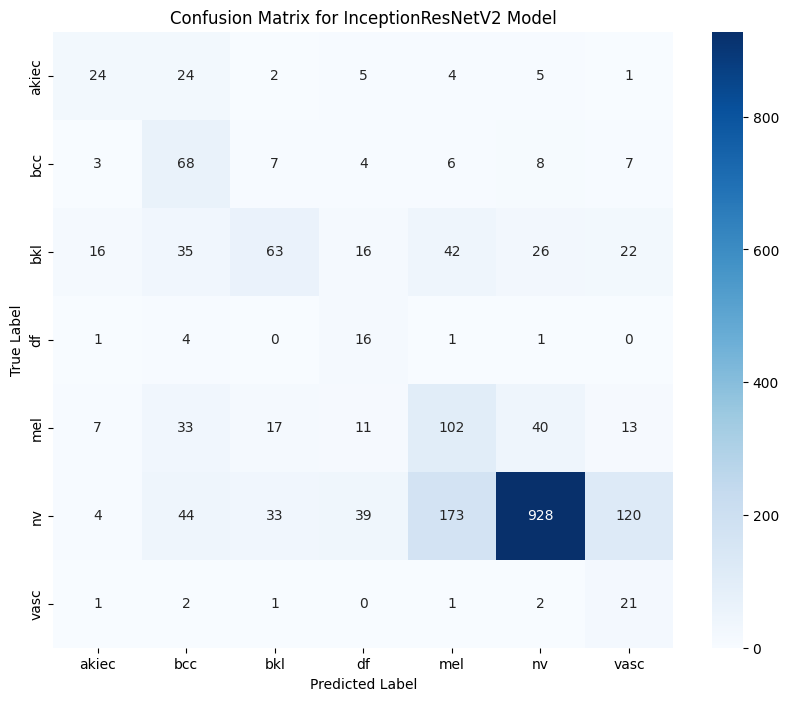

In [4]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Start training
print("\nStarting model training with InceptionResNetV2...")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    class_weight=class_weights_dict,
    callbacks=[early_stopping]
)
print("\nModel training finished.")

# Enhanced Final Evaluation
print("\nStarting final evaluation...")
loss, accuracy = model.evaluate(validation_dataset)

print("\n" + "="*40)
print("     Final Results on the Validation Set (InceptionResNetV2)")
print("="*40)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("="*40)

# Detailed Classification Report
print("\n" + "="*50)
print("     Detailed Classification Report")
print("="*50)
true_labels = np.concatenate([y for x, y in validation_dataset], axis=0)
predictions = model.predict(validation_dataset)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names, zero_division=0)
print(report)

# Confusion Matrix
print("\n" + "="*50)
print("     Confusion Matrix")
print("="*50)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for InceptionResNetV2 Model')
plt.show()